In [40]:
from pylab import *

from casadi import *
import time
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




In [41]:
normalization = 1e9
δ  = 0.02
α  = 0.045007414
κ  = 2.094215255
pf = 20.76
ζ  = 1.66e-4 * normalization 
p1 =  38.29
p2 =  44.75

In [42]:
#Probability Matrix
from scipy.linalg import logm, expm
dτ=1/12
P = np.matrix([[0.984, 0.016],[0.035, 0.965]]) 
M = logm(P)/dτ
m1 = M[0,1]
m2 = M[1,0]

In [43]:
#Site Data
df = pd.read_csv("data/calibration_25SitesModel.csv")
z0_list = df['z_2017_25Sites'].to_numpy()
γ_list  = np.array([527.98463153, 464.47078675, 526.53954022, 624.39105653,
       695.38166111, 629.64484806, 505.10373762, 504.09518168,
       576.73137471, 519.83052765, 349.40083023, 245.92570894,
       897.72238187, 638.90635523, 534.28452672, 644.28456552,
       398.11181448, 334.5368145 , 847.76691689, 554.23786853,
       494.23225948, 353.8871185 , 381.45012617, 335.34233175,
       277.42332872])
x0_list = γ_list *df['forestArea_2017_ha_25Sites'].to_numpy()
θ_list  = np.array([0.12989313, 0.16848182, 0.44782733, 1.13767822, 1.72960849,
       0.14763087, 0.22179752, 0.82148626, 1.25406137, 1.76982429,
       1.77622964, 1.40128859, 1.46828954, 1.31649519, 1.62287647,
       1.51144155, 1.6109034 , 1.94439364, 2.14770204, 2.17717749,
       2.9201727 , 2.40419028, 2.04193967, 2.8172804 , 2.65842921])

Z0_list = z0_list/ normalization
X0_list = x0_list/ normalization

z̄ = (df['zbar_2017_25Sites'].to_numpy() )/normalization
n = len(z̄)

In [44]:
#Construct Matrix A
Az = np.zeros((n, n+2))
Ax = np.zeros((1, n+2-0))

Ax[0,0:n-0] = -α *γ_list[0:n]
Ax[0, -1] = np.sum(α*γ_list[0:n] * z̄[0:n])
Ax[0,-2]  = -α

A  = np.concatenate((Az, Ax, np.zeros((1, n+2-0))), axis=0)

In [45]:
# Construct Matrix B
Bz = np.identity((n-0))
Bx = (np.zeros((1,n-0)))

B  = np.concatenate((Bz, Bx,  np.zeros((1, n-0))), axis=0)

In [46]:
# Construct Matrix B
Dz =   np.zeros((n-0,n-0))
Dx = -(np.ones((1,n-0))*γ_list[0:n])

D  = np.concatenate((Dz, Dx, np.zeros((1, n-0))), axis=0)

In [47]:
T   = 200
N   = T

dt = T/N
Y = MX.sym('Y',n+2-0) 
up = MX.sym('up',n-0) 
um = MX.sym('um',n-0) 

rhs = (sparsify(A)@Y + sparsify(B)@(up-um) + sparsify(D)@(up))*dt + Y
f = Function('f', [Y, um, up],[rhs])


import math
ds_vect = np.zeros((N+1,1))
for i in range(N+1):
    ds_vect[i]=math.exp(-δ*i*dt)
    
P= expm(M*dt)


In [48]:
opti = casadi.Opti()

# Decision variables for states

X = opti.variable(n+2-0 ,N+1)
# Aliases for states

Up = opti.variable(n-0,N)
Um = opti.variable(n-0,N)
Ua = opti.variable(1,N)
# 1.2: Parameter for initial state
ic = opti.parameter(n+2-0)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:,k+1]==f(X[:,k],Um[:,k], Up[:,k]))
    
# Initial and terminal constraints
opti.subject_to(X[:,0] == ic)
opti.subject_to(opti.bounded(0,X[0:n-0,:],z̄[0:n]))
# Objective: regularization of controls
# 1.1: added regularization
for k in range(n-0):
    opti.subject_to(opti.bounded(0,Um[k,:],inf))
    opti.subject_to(opti.bounded(0,Up[k,:],inf))

opti.subject_to(Ua == sum1(Up+Um)**2 )

opti.minimize( sum2(ds_vect[0:N,:].T*(Ua* ζ/2 ))
              - sum2(ds_vect[0:N,:].T*(pf*X[-2,1:] - pf*X[-2,0:-1]  ))
              - sum2(ds_vect.T*sum1((p2*θ_list - pf*κ )*X[0:n-0,:] )))




In [49]:
# solve optimization problem 
options = dict()
options["print_time"] = False
options["expand"]     = True
options["ipopt"]      = {
                    'print_level': 0,
                    'fast_step_computation':            'yes',
                    'mu_allow_fast_monotone_decrease':  'yes',
                    'warm_start_init_point':            'yes',
                        }
opti.solver('ipopt',options)

t1 = time.time()
opti.set_value(ic,vertcat(Z0_list,np.sum(X0_list),1))
sol = opti.solve()
disp(f'Initial, time: {time.time()-t1}')


Initial, time: 34.13823413848877


In [50]:
np.save('det_ξ_10_pe_20',sol.value(X))

In [51]:
df=pd.DataFrame(np.load('det_ξ_10_pe_20.npy'))
df.to_csv('det_ξ_10_pe_20.csv')

In [11]:
sol2=sol.value(X)

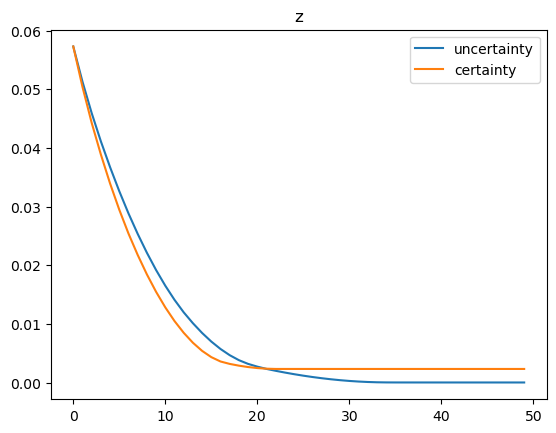

In [52]:
plt.plot(np.sum(sol.value(X)[0:n,0:50].T, axis=1))
plt.plot(np.sum(sol2[0:n,0:50].T, axis=1))
plt.legend(['uncertainty','certainty'])
plt.title('z')
plt.show()

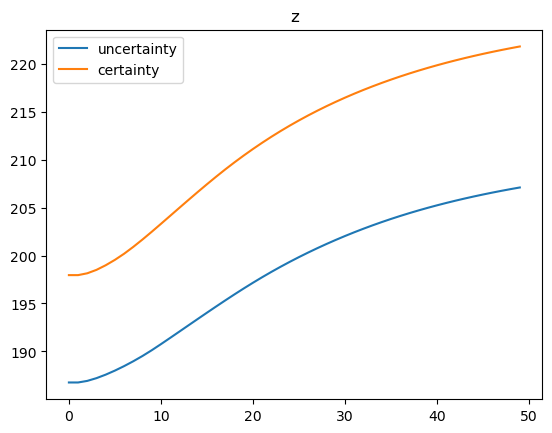

In [37]:
plt.plot((sol.value(X)[n,0:50].T))
plt.plot((sol2[n,0:50].T))
plt.legend(['uncertainty','certainty'])
plt.title('z')
plt.show()

In [12]:
np.save('det_ξ_25_pe_5',sol.value(X))

In [13]:
df=pd.DataFrame(np.load('det_ξ_25_pe_5.npy'))
df.to_csv('det_ξ_25_pe_5.csv')

In [11]:
inputs = [ic,opti.x, opti.lam_g]
outputs = [Up[:,0],Um[:,0],opti.x, opti.lam_g]
current_x = vertcat(Z0_list[0:n],np.sum(X0_list[0:n]),1)

mpc_step = opti.to_function('mpc_step',inputs,outputs)
nn = 50

x_history  = DM.zeros(n+2,nn+1)
u_history  = DM.zeros(n,nn)
um_history = DM.zeros(n,nn)
up_history = DM.zeros(n,nn)

up  = sol.value(Up[:,0]) 
um  = sol.value(Um[:,0])
x   = sol.value(opti.x)
lam = sol.value(opti.lam_g)


x_history[:,0] = current_x
pre_price = p2
t1 = time.time()
for i in range(nn):
    t0 = time.time()
    u_history[:,i]  = up - um
    um_history[:,i] = um
    up_history[:,i] = up
    current_x = f(current_x,um, up)
    [up,um,x,lam] = mpc_step(current_x,x,lam)
    x_history[:,i+1] = current_x
    disp(f'Year: {i+1}, time: {time.time()-t0}')
disp(f'Finale, time: {time.time()-t1}')


Year: 1, time: 1.393894910812378
Year: 2, time: 1.4591102600097656
Year: 3, time: 1.5014500617980957
Year: 4, time: 1.5379199981689453
Year: 5, time: 1.4863290786743164
Year: 6, time: 1.3831050395965576
Year: 7, time: 1.468027114868164
Year: 8, time: 1.8277990818023682
Year: 9, time: 1.7628898620605469
Year: 10, time: 1.470473051071167
Year: 11, time: 1.4287099838256836
Year: 12, time: 1.7237498760223389
Year: 13, time: 1.6419668197631836
Year: 14, time: 1.65364408493042
Year: 15, time: 1.709245204925537
Year: 16, time: 1.808694839477539
Year: 17, time: 1.6676149368286133
Year: 18, time: 1.5204567909240723
Year: 19, time: 1.256669282913208
Year: 20, time: 1.3253579139709473
Year: 21, time: 1.1464300155639648
Year: 22, time: 1.3157610893249512
Year: 23, time: 1.2744381427764893
Year: 24, time: 1.2816991806030273
Year: 25, time: 1.0889737606048584
Year: 26, time: 1.0590317249298096
Year: 27, time: 1.213331937789917
Year: 28, time: 1.2386269569396973
Year: 29, time: 1.1364870071411133
Yea

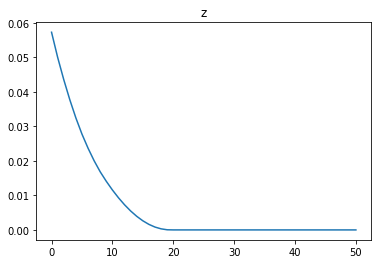

In [16]:
plt.plot(np.sum(x_history[0:n,0:].T, axis=1))
plt.title('z')
plt.show()

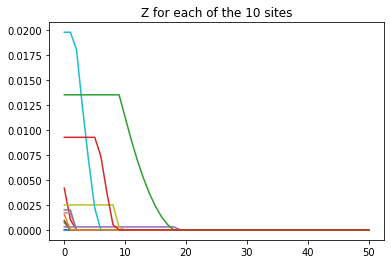

In [17]:
plt.plot(x_history[0:n,0:].T)
plt.title('Z for each of the 10 sites')
plt.show()

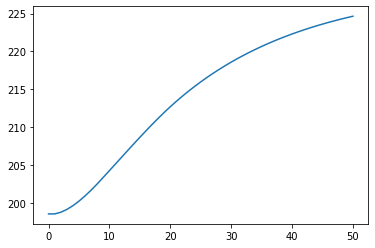

In [13]:
plt.plot(np.sum(x_history[-2,0:].T, axis=1))
plt.show()